In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-kaglle/kaggle.json
/kaggle/input/ml-competition-2024-for-ukrainians/sample_submission.csv
/kaggle/input/ml-competition-2024-for-ukrainians/train.csv
/kaggle/input/ml-competition-2024-for-ukrainians/test.csv
/kaggle/input/big-sales-prediction-dataset/Big Sales Data.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import lightgbm as lgb
# Load data
train_data = pd.read_csv('/kaggle/input/ml-competition-2024-for-ukrainians/train.csv')
test_data = pd.read_csv('/kaggle/input/ml-competition-2024-for-ukrainians/test.csv')
test_ids = test_data['id'] if 'id' in test_data.columns else test_data.index
additional_data = pd.read_csv('/kaggle/input/big-sales-prediction-dataset/Big Sales Data.csv')
#train_data = pd.concat([train_data, additional_data], axis=0)
sample_submission = pd.read_csv('/kaggle/input/ml-competition-2024-for-ukrainians/sample_submission.csv')

# EDA

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

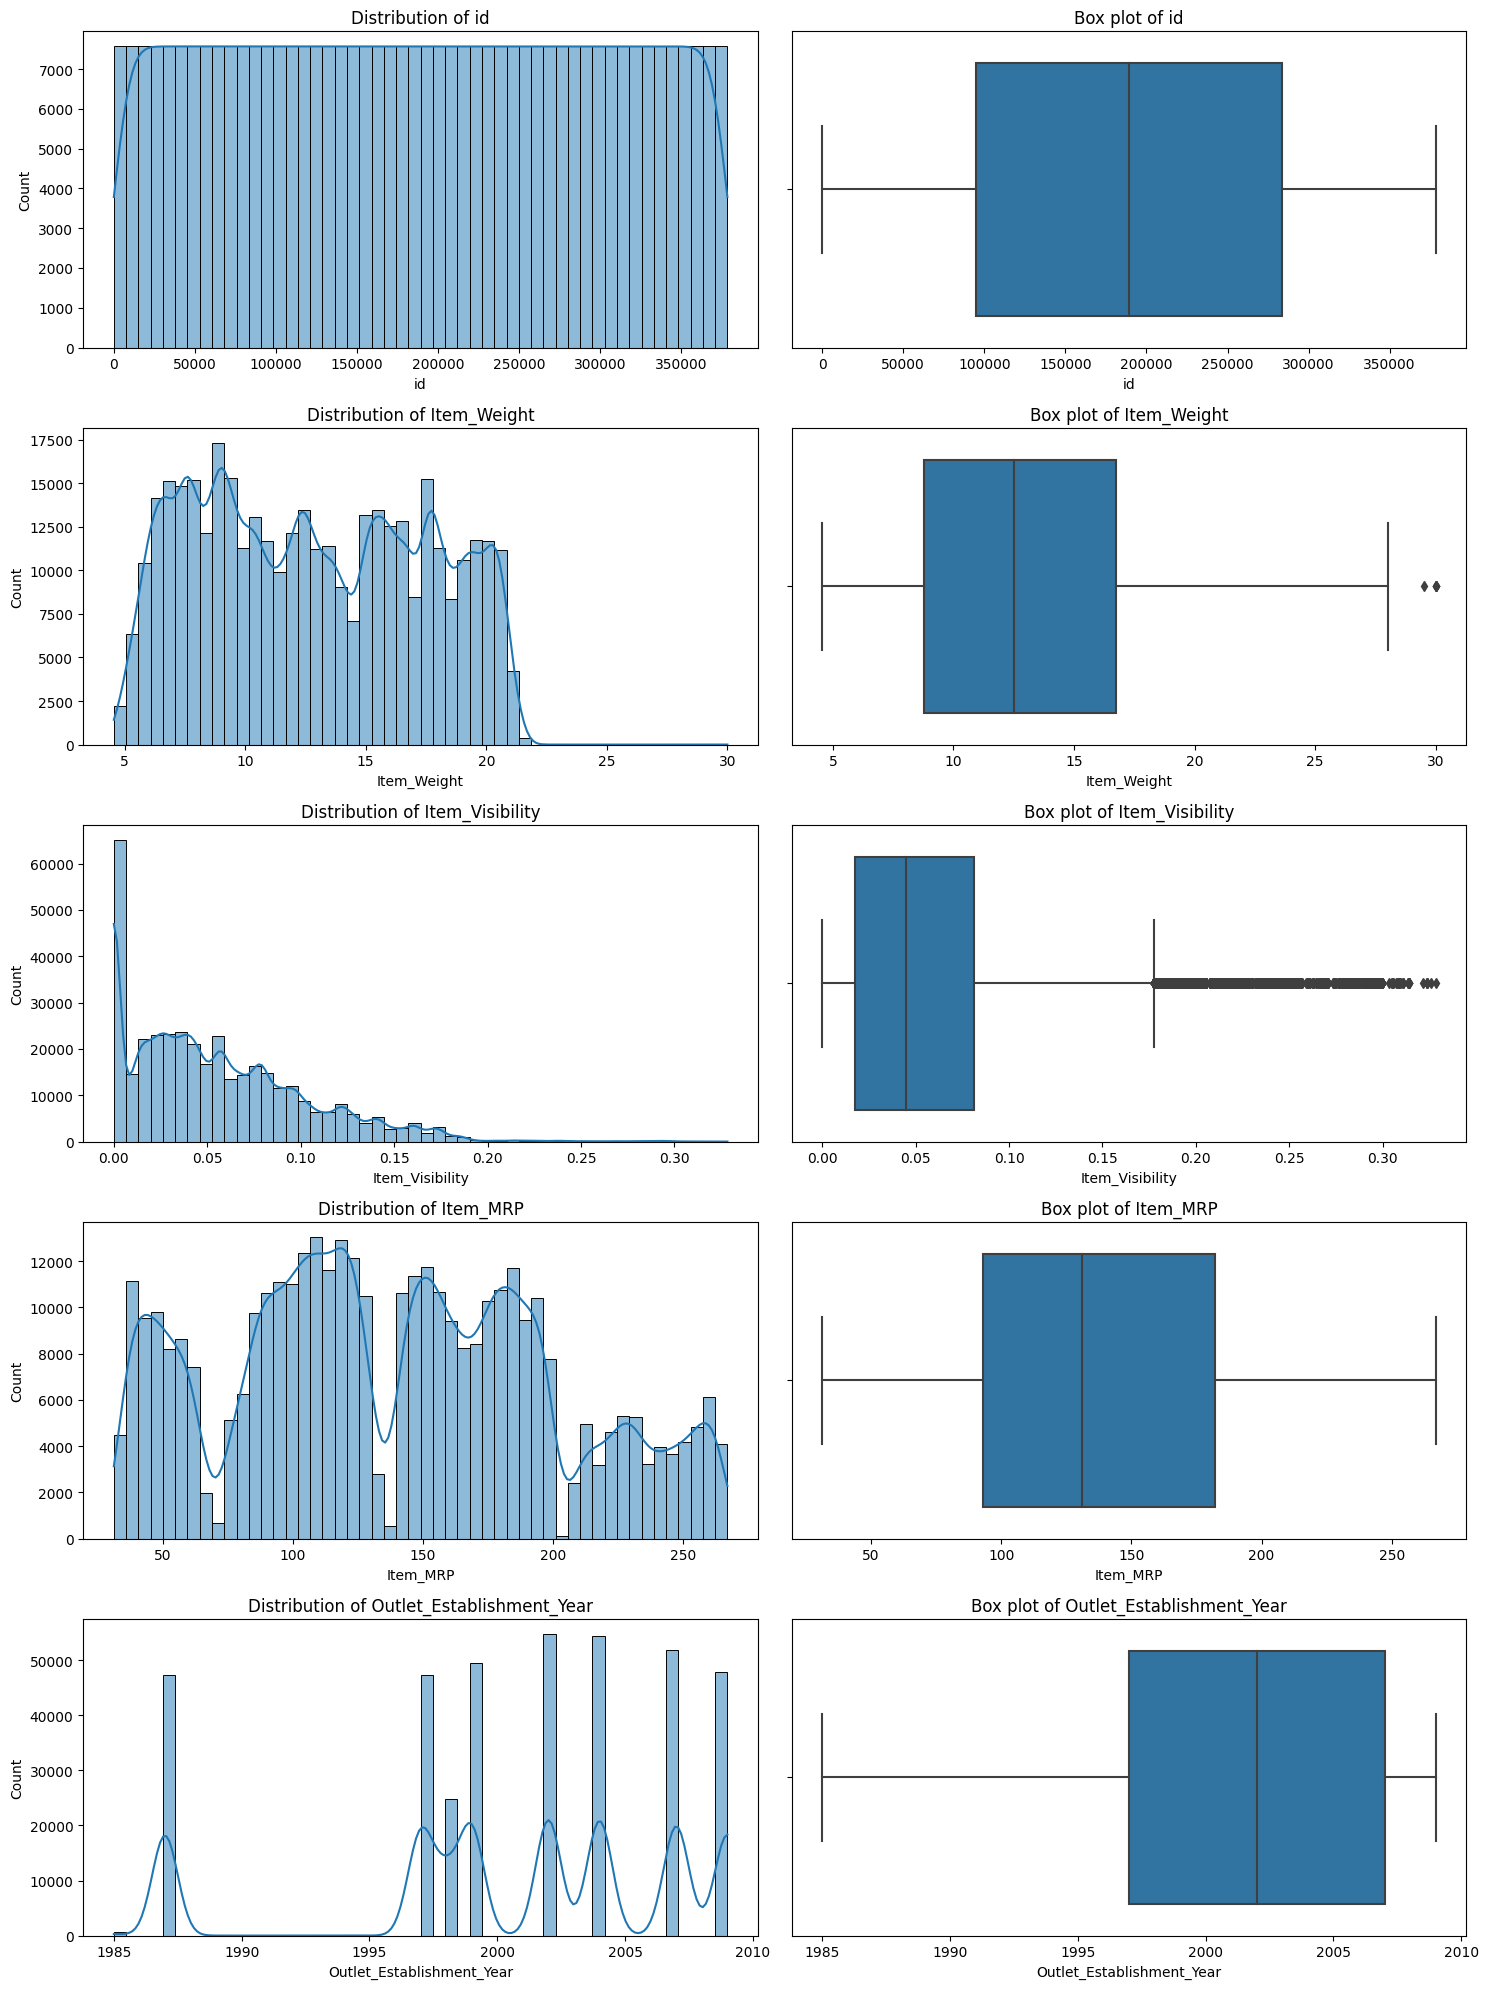

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numeric features
numeric_features = train_data.select_dtypes(include=[np.number]).columns.tolist()

# Remove the target variable from the list
numeric_features.remove('Item_Outlet_Sales')

# Plot histograms and box plots for each numeric feature
plt.figure(figsize=(15, 20))
for i, feature in enumerate(numeric_features):
    plt.subplot(len(numeric_features), 2, 2*i+1)
    sns.histplot(train_data[feature], bins=50, kde=True)
    plt.title(f'Distribution of {feature}')
    
    plt.subplot(len(numeric_features), 2, 2*i+2)
    sns.boxplot(x=train_data[feature])
    plt.title(f'Box plot of {feature}')

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


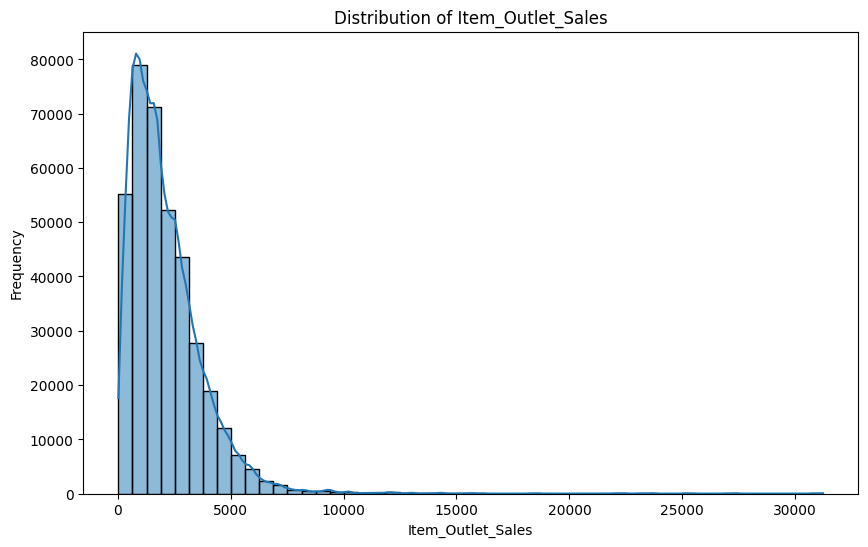

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(train_data['Item_Outlet_Sales'], bins=50, kde=True)
plt.title('Distribution of Item_Outlet_Sales')
plt.xlabel('Item_Outlet_Sales')
plt.ylabel('Frequency')
plt.show()

# Feature Engineering

In [5]:
# Aggregate item information
item_info = train_data.groupby('Item_Identifier').agg({
    'Item_Weight': 'mean',
    'Item_Fat_Content': lambda x: x.mode()[0],
    'Item_Type': lambda x: x.mode()[0]
}).reset_index()

# Aggregate outlet information
outlet_info = train_data.groupby('Outlet_Identifier').agg({
    'Outlet_Establishment_Year': 'max',
    'Outlet_Size': lambda x: x.mode()[0],
    'Outlet_Location_Type': lambda x: x.mode()[0],
    'Outlet_Type': lambda x: x.mode()[0]
}).reset_index()

# Merge aggregated item and outlet information back into the datasets
train_data = train_data.drop(columns=['Item_Weight', 'Item_Fat_Content', 'Item_Type', 
                                      'Outlet_Establishment_Year', 'Outlet_Size', 
                                      'Outlet_Location_Type', 'Outlet_Type'])

train_data = train_data.merge(item_info, on='Item_Identifier', how='left')
train_data = train_data.merge(outlet_info, on='Outlet_Identifier', how='left')

test_data = test_data.drop(columns=['Item_Weight', 'Item_Fat_Content', 'Item_Type', 
                                    'Outlet_Establishment_Year', 'Outlet_Size', 
                                    'Outlet_Location_Type', 'Outlet_Type'])

test_data = test_data.merge(item_info, on='Item_Identifier', how='left')
test_data = test_data.merge(outlet_info, on='Outlet_Identifier', how='left')

In [6]:
# Feature Engineering
train_data['Item_Visibility_MRP_Ratio'] = train_data['Item_Visibility'] / train_data['Item_MRP']
test_data['Item_Visibility_MRP_Ratio'] = test_data['Item_Visibility'] / test_data['Item_MRP']
train_data['Item_Weight_Visibility_Ratio'] = train_data['Item_Weight'] / train_data['Item_Visibility']
test_data['Item_Weight_Visibility_Ratio'] = test_data['Item_Weight'] / test_data['Item_Visibility']
train_data['Item_Visibility_Squared'] = train_data['Item_Visibility'] ** 2
test_data['Item_Visibility_Squared'] = test_data['Item_Visibility'] ** 2

#Create a new feature for Outlet Age
train_data['Outlet_Age'] = 2024 - train_data['Outlet_Establishment_Year']
test_data['Outlet_Age'] = 2024 - test_data['Outlet_Establishment_Year']

# Clean the Item_Fat_Content column
train_data['Item_Fat_Content'] = train_data['Item_Fat_Content'].replace(['LF', 'low fat'], 'Low Fat').replace('reg', 'Regular')
test_data['Item_Fat_Content'] = test_data['Item_Fat_Content'].replace(['LF', 'low fat'], 'Low Fat').replace('reg', 'Regular')

# Combine similar Item_Type categories
train_data['Item_Type_Combined'] = train_data['Item_Type'].apply(lambda x: 'Non-Consumable' if x in ['Household', 'Health and Hygiene', 'Others'] else 'Consumable')
test_data['Item_Type_Combined'] = test_data['Item_Type'].apply(lambda x: 'Non-Consumable' if x in ['Household', 'Health and Hygiene', 'Others'] else 'Consumable')

# Data preparation

In [7]:
# Encoding categorical variables
categorical_columns = ['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Type_Combined']
train_data = pd.get_dummies(train_data, columns=categorical_columns)
test_data = pd.get_dummies(test_data, columns=categorical_columns)

# Aligning test data columns with train data columns
test_data = test_data.reindex(columns=train_data.columns, fill_value=0)

In [8]:
# Replace zero visibility values with the mean visibility
mean_visibility = train_data['Item_Visibility'].mean()
train_data['Item_Visibility'] = train_data['Item_Visibility'].replace(0, mean_visibility)
test_data['Item_Visibility'] = test_data['Item_Visibility'].replace(0, mean_visibility)

In [9]:
# Remove outliers in Item_Outlet_Sales using IQR method
Q1_sales = train_data['Item_Outlet_Sales'].quantile(0.25)
Q3_sales = train_data['Item_Outlet_Sales'].quantile(0.75)
IQR_sales = Q3_sales - Q1_sales
train_data = train_data[~((train_data['Item_Outlet_Sales'] < (Q1_sales - 1.5 * IQR_sales)) | 
                              (train_data['Item_Outlet_Sales'] > (Q3_sales + 1.5 * IQR_sales)))]

# Remove outliers in Item_Weight using IQR method
Q1_weight = train_data['Item_Weight'].quantile(0.25)
Q3_weight = train_data['Item_Weight'].quantile(0.75)
IQR_weight = Q3_weight - Q1_weight
train_data = train_data[~((train_data['Item_Weight'] < (Q1_weight - 1.5 * IQR_weight)) | 
                              (train_data['Item_Weight'] > (Q3_weight + 1.5 * IQR_weight)))]


In [10]:
# Checking for missing values in train and test data
print(train_data.isnull().sum())
print(test_data.isnull().sum())
train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
# Handle missing values
train_data['Item_Weight'].fillna(train_data['Item_Weight'].mean(), inplace=True)
test_data['Item_Weight'].fillna(test_data['Item_Weight'].mean(), inplace=True)
# Fill NaNs by column means only if they have NaNs
for col in train_data.columns:
    if train_data[col].isna().any():
        train_data[col].fillna(train_data[col].mean(), inplace=True)
for col in test_data.columns:
    if test_data[col].isna().any():
        test_data[col].fillna(test_data[col].mean(), inplace=True)

id                                   0
Item_Identifier                      0
Item_Visibility                      0
Item_MRP                             0
Outlet_Identifier                    0
Item_Outlet_Sales                    0
Item_Weight                          0
Item_Type                            0
Outlet_Establishment_Year            0
Item_Visibility_MRP_Ratio            0
Item_Weight_Visibility_Ratio         0
Item_Visibility_Squared              0
Outlet_Age                           0
Item_Fat_Content_Low Fat             0
Item_Fat_Content_Regular             0
Outlet_Size_High                     0
Outlet_Size_Medium                   0
Outlet_Size_Small                    0
Outlet_Location_Type_Tier 1          0
Outlet_Location_Type_Tier 2          0
Outlet_Location_Type_Tier 3          0
Outlet_Type_Grocery Store            0
Outlet_Type_Supermarket Type1        0
Outlet_Type_Supermarket Type2        0
Outlet_Type_Supermarket Type3        0
Item_Type_Combined_Consum

/tmp/ipykernel_34/2705562751.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Item_Weight'].fillna(train_data['Item_Weight'].mean(), inplace=True)
/tmp/ipykernel_34/2705562751.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

In [11]:
# Create interaction features
numerical_columns = ['Item_Weight', 'Item_Visibility', 'Item_MRP']
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
train_interactions = interaction.fit_transform(train_data[numerical_columns])
test_interactions = interaction.transform(test_data[numerical_columns])

interaction_feature_names = interaction.get_feature_names_out(numerical_columns)
train_interaction_df = pd.DataFrame(train_interactions, columns=interaction_feature_names).drop(columns=numerical_columns)
test_interaction_df = pd.DataFrame(test_interactions, columns=interaction_feature_names).drop(columns=numerical_columns)

train_data = train_data.reset_index(drop=True).join(train_interaction_df)
test_data = test_data.reset_index(drop=True).join(test_interaction_df)

In [12]:
# Dropping the target variable from test data
test_data.drop(['Item_Outlet_Sales'], axis=1, inplace=True)
# Apply log transformation to the target variable
train_data['Log_Item_Outlet_Sales'] = np.log1p(train_data['Item_Outlet_Sales'])
# Drop 'Item_Identifier' and 'Item_Type'
train_data.drop(columns=['Item_Identifier', 'Item_Type', 'Outlet_Identifier'], inplace=True)
test_data.drop(columns=['Item_Identifier', 'Item_Type', 'Outlet_Identifier'], inplace=True)

In [13]:
# Calculate skewness for each numeric feature
skewness = train_data[numeric_features].skew().sort_values(ascending=False)
print("Skewness of numeric features:")
print(skewness)

Skewness of numeric features:
Item_Visibility              1.304446
Item_MRP                     0.203766
Item_Weight                  0.098909
id                           0.000265
Outlet_Establishment_Year   -0.174367
dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


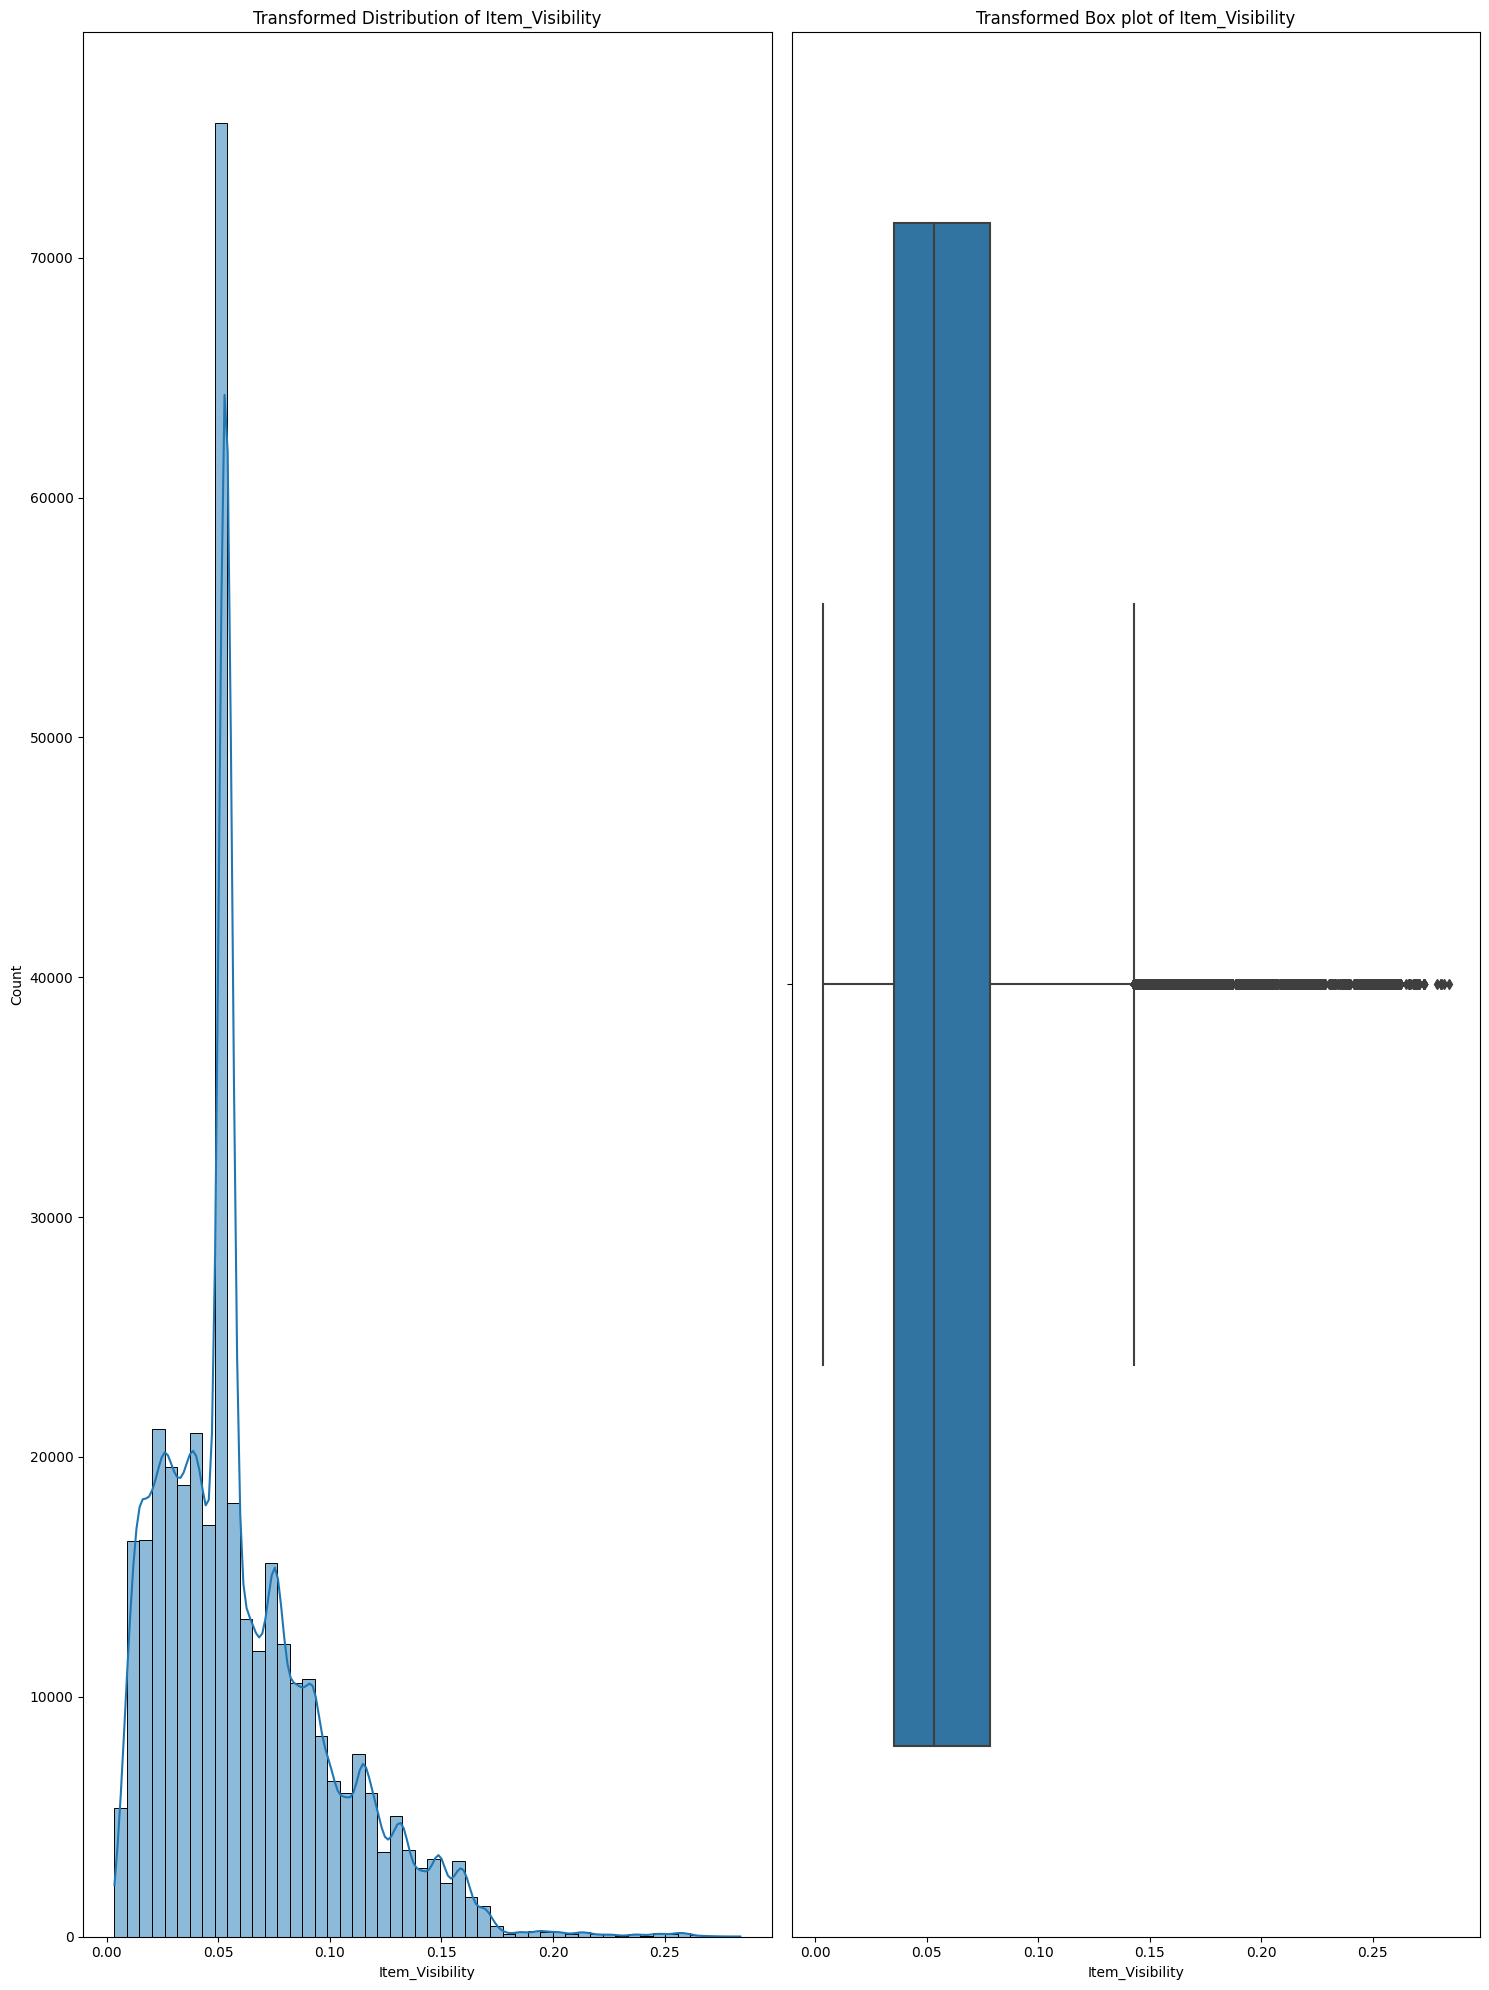

In [14]:
# Define threshold for skewness
skewness_threshold = 0.5

# Apply log transformation for highly skewed features
for feature in skewness[skewness > skewness_threshold].index:
    train_data[feature] = np.log1p(train_data[feature])
    test_data[feature] = np.log1p(test_data[feature])

# Plot the transformed features to check the effect
plt.figure(figsize=(15, 20))
for i, feature in enumerate(skewness[skewness > skewness_threshold].index):
    plt.subplot(len(skewness[skewness > skewness_threshold]), 2, 2*i+1)
    sns.histplot(train_data[feature], bins=50, kde=True)
    plt.title(f'Transformed Distribution of {feature}')
    
    plt.subplot(len(skewness[skewness > skewness_threshold]), 2, 2*i+2)
    sns.boxplot(x=train_data[feature])
    plt.title(f'Transformed Box plot of {feature}')

plt.tight_layout()
plt.show()

In [15]:
# Use the transformed target variable for training
y = train_data['Log_Item_Outlet_Sales']
X = train_data.drop(['Log_Item_Outlet_Sales', 'Item_Outlet_Sales'], axis=1)

In [16]:
# Scaling features
scaler = StandardScaler()
X = scaler.fit_transform(X)
test_data = scaler.transform(test_data)

In [17]:
# Splitting the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Parametrs tuning

In [18]:
import optuna
# Custom scoring function for RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# Define LightGBM dataset
train_data_lgb = lgb.Dataset(X_train, label=y_train)
valid_data_lgb = lgb.Dataset(X_valid, label=y_valid)

early_stopping_callback = lgb.early_stopping(stopping_rounds=10, verbose=False)
# Objective function for Optuna
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1.0),
        'early_stopping_rounds': 10,
        'device_type': 'gpu'
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[early_stopping_callback])
    y_pred = model.predict(X_valid)
    return rmsle(y_valid, y_pred)

# Run Optuna optimization
#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=500, timeout=9000)

# Best hyperparameters
#best_params = study.best_params
best_params_lgb = {'num_leaves': 48, 'learning_rate': 0.08018531482180792, 'n_estimators': 826, 'subsample': 0.7708744069865798, 'colsample_bytree': 0.7170960651769799, 'reg_alpha': 0.8129512960915664, 'reg_lambda': 0.81} #'reg_lambda': 0.15618746877867024}

In [19]:
from catboost import CatBoostRegressor
def catboost_objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'task_type': 'GPU'  # Use GPU
    }
    model = CatBoostRegressor(**params, verbose=0)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=10)
    y_pred = model.predict(X_valid)
    return rmsle(y_valid, y_pred)

def xgb_objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10.0),
        'tree_method': 'hist',
        'device': 'gpu',
        'predictor': 'gpu_predictor'  # Use GPU predictor
    }
    model = xgb.XGBRegressor(**params,  n_gpus = -1)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    y_pred = model.predict(X_valid)
    return rmsle(y_valid, y_pred)

In [20]:
import xgboost as xgb
xgb_study = optuna.create_study(direction='minimize')
xgb_study.optimize(xgb_objective, n_trials=100, timeout=1800, gc_after_trial=True)
# Best hyperparameters
best_params_xgb = xgb_study.best_params

[I 2024-06-30 09:41:17,574] A new study created in memory with name: no-name-2216d276-4810-465a-ba1e-b146b3ae3833
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:41:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_gpus", "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:41:25] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
[I 2024-06-30 09:41:25,528] Trial 0 finished with value: 0.6866025275131504 and parameters: {'max_depth': 5, 'learni

In [21]:
best_params_xgb = {'max_depth': 7, 'learning_rate': 0.030625397111463087, 'n_estimators': 1268, 'subsample': 0.9068583461131451, 'colsample_bytree': 0.6353753237797095, 'reg_alpha': 0.5300259447790302, 'reg_lambda': 0.9190146428243264, 'min_child_weight': 6, 'gamma': 0.150508586068591, 'scale_pos_weight': 4.48025903467417}

{'max_depth': 7,
 'learning_rate': 0.030625397111463087,
 'n_estimators': 1268,
 'subsample': 0.9068583461131451,
 'colsample_bytree': 0.6353753237797095,
 'reg_alpha': 0.5300259447790302,
 'reg_lambda': 0.9190146428243264,
 'min_child_weight': 6,
 'gamma': 0.150508586068591,
 'scale_pos_weight': 4.48025903467417}

In [22]:
catboost_study = optuna.create_study(direction='minimize')
catboost_study.optimize(catboost_objective, n_trials=50)
best_params_catboost = catboost_study.best_params

[I 2024-06-30 09:52:58,954] A new study created in memory with name: no-name-b6f37c09-483d-46d6-acdf-d486f964c7de
[I 2024-06-30 09:53:21,802] Trial 0 finished with value: 0.6906483014666486 and parameters: {'iterations': 676, 'depth': 9, 'learning_rate': 0.04371951085228579, 'l2_leaf_reg': 2.8464527926451995, 'bagging_temperature': 0.7591498437283337}. Best is trial 0 with value: 0.6906483014666486.
[I 2024-06-30 09:53:29,943] Trial 1 finished with value: 0.6894458399674939 and parameters: {'iterations': 965, 'depth': 10, 'learning_rate': 0.08067247202554148, 'l2_leaf_reg': 7.554122768777017, 'bagging_temperature': 0.24537374263471845}. Best is trial 1 with value: 0.6894458399674939.
[I 2024-06-30 09:53:37,279] Trial 2 finished with value: 0.6912499490396145 and parameters: {'iterations': 489, 'depth': 4, 'learning_rate': 0.0262287170272296, 'l2_leaf_reg': 5.125488377990309, 'bagging_temperature': 0.9554418585284193}. Best is trial 1 with value: 0.6894458399674939.
[I 2024-06-30 09:53:

In [23]:
best_params_catboost = {'iterations': 787, 'depth': 8, 'learning_rate': 0.06547923476860129, 'l2_leaf_reg': 9.989030634152073, 'bagging_temperature': 0.17580417046712032}

{'iterations': 787,
 'depth': 8,
 'learning_rate': 0.06547923476860129,
 'l2_leaf_reg': 9.989030634152073,
 'bagging_temperature': 0.17580417046712032}

# Model training

In [24]:
# Train final models
xgb_model = xgb.XGBRegressor(**best_params_xgb, tree_method='hist', device='gpu', predictor='gpu_predictor',  n_gpus = -1)
lgb_model = lgb.LGBMRegressor(**best_params_lgb, device_type='gpu')
catboost_model = CatBoostRegressor(**best_params_catboost, task_type='GPU', verbose=0)

In [34]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LogisticRegression
# Ensemble using stacking
final_model = StackingRegressor(
    estimators=[
        ('lgb', lgb_model),
        ('catboost', catboost_model),
        ('xgb', xgb_model),
        ('rf', RandomForestRegressor(n_estimators=100))
    ],
    final_estimator=RandomForestRegressor(n_estimators=100)
)

final_model.fit(X_train, y_train)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2610
[LightGBM] [Info] Number of data points in the train set: 294144, number of used features: 26
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 18 dense feature groups (5.61 MB) transferred to GPU in 0.005496 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.315529


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:17:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_gpus", "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2610
[LightGBM] [Info] Number of data points in the train set: 235315, number of used features: 26
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 18 dense feature groups (4.49 MB) transferred to GPU in 0.004641 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.317613
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2610
[LightGBM] [Info] Number of data points in the train set: 235315, number of used features: 26
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM]

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:28:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_gpus", "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:28:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_gpus", "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:28:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_gpus", "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:28:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_gpus", "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:28:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_g

StackingRegressor(estimators=[('lgb',
                               LGBMRegressor(colsample_bytree=0.7170960651769799,
                                             device_type='gpu',
                                             learning_rate=0.08018531482180792,
                                             n_estimators=826, num_leaves=48,
                                             reg_alpha=0.8129512960915664,
                                             reg_lambda=0.81,
                                             subsample=0.7708744069865798)),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x78cb72cabc40>),
                              ('xgb',
                               XGBRegressor(base_score=None...
                                            learning_rate=0.030625397111463087,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None, min_child_weight=6,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1268, n_gpus=-1,
                                            n_jobs=None, num_parallel_tree=None, ...)),
                              ('rf', RandomForestRegressor())],
                  final_estimator=RandomForestRegressor())

In [26]:
# Train the final model with the best hyperparameters
#final_model = lgb.LGBMRegressor(**best_params_lgb, device_type='gpu')
#final_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[early_stopping_callback])

# Prediction

In [35]:
# Making predictions on the validation set
y_pred = final_model.predict(X_valid)
y_pred = np.maximum(0, y_pred) 
# Calculating RMSLE
rmsle_value = rmsle(y_valid, y_pred)
print(f'RMSLE: {rmsle_value}')

RMSLE: 0.7040455798266094


In [36]:
# Making predictions on the test set
test_preds = final_model.predict(test_data)
test_preds = np.expm1(test_preds)
# Preparing the submission file
submission = pd.DataFrame({
    'id': test_ids,
    'Item_Outlet_Sales': test_preds
})

submission.to_csv('/kaggle/working/submission-lgbm-070.csv', index=False)

# Blending

In [38]:
from sklearn.linear_model import LinearRegression
# Split data
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Base models
model_xgb = xgb_model
model_lgb = lgb_model
model_rf = RandomForestRegressor(n_estimators=100)

# Train base models
model_xgb.fit(X_train, y_train)
model_lgb.fit(X_train, y_train)
model_rf.fit(X_train, y_train)

# Generate predictions for the meta-model
preds_xgb = model_xgb.predict(X_test_meta)
preds_lgb = model_lgb.predict(X_test_meta)
preds_rf = model_rf.predict(X_test_meta)

# Stack predictions for the meta-model
stacked_preds = np.column_stack((preds_xgb, preds_lgb, preds_rf))

# Meta-model
meta_model = LinearRegression()
meta_model.fit(stacked_preds, y_test_meta)

# Blending predictions
preds_xgb_full = model_xgb.predict(X_valid)
preds_lgb_full = model_lgb.predict(X_valid)
preds_rf_full = model_rf.predict(X_valid)

stacked_preds_full = np.column_stack((preds_xgb_full, preds_lgb_full, preds_rf_full))
blended_preds = meta_model.predict(stacked_preds_full)

# Evaluate
rmsle_value = rmsle(y_valid, blended_preds)
print(f'RMSLE: {rmsle_value}')

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:21:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_gpus", "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2610
[LightGBM] [Info] Number of data points in the train set: 294144, number of used features: 26
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 18 dense feature groups (5.61 MB) transferred to GPU in 0.005665 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 7.315529
RMSLE: 0.728909996547675


In [39]:
test_preds_xgb = model_xgb.predict(test_data)
test_preds_lgb = model_lgb.predict(test_data)
test_preds_rf = model_rf.predict(test_data)

stacked_test_preds = np.column_stack((test_preds_xgb, test_preds_lgb, test_preds_rf))
blended_test_preds = meta_model.predict(stacked_test_preds)
# Preparing the submission file
submission = pd.DataFrame({
    'id': test_ids,
    'Item_Outlet_Sales': test_preds
})

submission.to_csv('/kaggle/working/submission-blending.csv', index=False)

# Submission to the competition

In [40]:
import json
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Assuming you've uploaded 'kaggle.json' to the notebook's environment

# Load the 'kaggle.json' file
with open('/kaggle/input/test-kaglle/kaggle.json') as f:
    kaggle_creds = json.load(f)

# Ensure the directory exists
os.makedirs('/root/.kaggle/', exist_ok=True)

# Write the credentials to the correct location
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_creds, f)

# Set permissions
os.chmod('/root/.kaggle/kaggle.json', 600)

# Authenticate the API
api = KaggleApi()
api.authenticate()

!kaggle competitions submit -c 'ml-competition-2024-for-ukrainians' -f '/kaggle/working/submission-blending.csv' -m "Blending"

100%|██████████████████████████████████████| 6.14M/6.14M [00:00<00:00, 8.58MB/s]
Successfully submitted to Kaggle Competition 2024 for Ukrainians